In [1]:
!pip install nnAudio
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 631.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 928.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.1 MB/s eta 0:00:0000:0100:01


In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="6"

import IPython.display as ipd
import pandas as pd
import numpy as np
import seaborn as sns
import librosa
import soundfile as sf
import re
import scipy
import torch
import matplotlib.pyplot as plt
import nnAudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import h5py
import gc
import seaborn as sns
import timeit
import albumentations as A
import lightning
import timm

from typing import Tuple, Dict, Any, Optional, Callable, Union
from glob import glob
from tqdm import tqdm
from joblib import Parallel, delayed
from tqdm import tqdm
from collections import Counter
from nnAudio.features.mel import MelSpectrogram
from torchaudio.transforms import AmplitudeToDB
from albumentations.pytorch import ToTensorV2
from lightning.pytorch.callbacks import Callback
from torchaudio.transforms import FrequencyMasking, TimeMasking
from sklearn.model_selection import StratifiedGroupKFold
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from time import time
from pprint import pprint
from collections import OrderedDict

%matplotlib inline

# Task

For this lecture we will consider [HMS - Harmful Brain Activity Classification](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/overview) Kaggle competition. 

It is not audio but rather signal classification task:

```
The goal of this competition is to detect and classify seizures and other types of harmful brain activity. You will develop a model trained on electroencephalography (EEG) signals recorded from critically ill hospital patients.
```

But you can apply pretty much the same methods as for audio classification.

In [3]:
DATA_ROOT = "/kaggle/input/ucu-hms-h5py"

# Agenda
1. [EDA](#EDA)
2. [Metric](#Metric)
3. [Data Preparation](#Data_Preparation)
4. [Validation](#Validation)
5. [Code Preparation](#Code_Preparation)
6. [Model](#Model)
7. [Training](#Training)
8. [Evaluation](#Evaluation)
9. [Homework](#Homework)

<a id='EDA'></a>
# Exploratory Data Analysis (EDA)

## Data Description

The goal of this competition is to detect and classify seizures and other types of harmful brain activity in electroencephalography (EEG) data. Even experts find this to be a challenging task and often disagree about the correct labels.

This is a code competition. Only a few examples from the test set are available for download. When your submission is scored the test folders will be replaced with versions containing the complete test set.

### Files

**train.csv** Metadata for the train set. The expert annotators reviewed 50 second long EEG samples plus matched spectrograms covering 10 a minute window centered at the same time and labeled the central 10 seconds. Many of these samples overlapped and have been consolidated. `train.csv` provides the metadata that allows you to extract the original subsets that the raters annotated.

- `eeg_id` - A unique identifier for the entire EEG recording.
- `eeg_sub_id` - An ID for the specific 50 second long subsample this row's labels apply to.
- `eeg_label_offset_seconds` - The time between the beginning of the consolidated EEG and this subsample.
- `spectrogram_id` - A unique identifier for the entire EEG recording.
- `spectrogram_sub_id` - An ID for the specific 10 minute subsample this row's labels apply to.
- `spectogram_label_offset_seconds` - The time between the beginning of the consolidated spectrogram and this subsample.
- `label_id` - An ID for this set of labels.
- `patient_id` - An ID for the patient who donated the data.
- `expert_consensus` - The consensus annotator label. Provided for convenience only.
- `[seizure/lpd/gpd/lrda/grda/other]_vote` - The count of annotator votes for a given brain activity class. The full names of the activity classes are as follows: lpd: lateralized periodic discharges, gpd: generalized periodic discharges, lrd: lateralized rhythmic delta activity, and grda: generalized rhythmic delta activity . A detailed explanations of these patterns is [available here](https://www.acns.org/UserFiles/file/ACNSStandardizedCriticalCareEEGTerminology_rev2021.pdf).

**test.csv** Metadata for the test set. As there are no overlapping samples in the test set, many columns in the train metadata don't apply.

- `eeg_id`
- `spectrogram_id`
- `patient_id`

**sample_submission.csv**

- eeg_id
- `[seizure/lpd/gpd/lrda/grda/other]_vote` - The target columns. Your predictions must be probabilities. Note that the test samples had between 3 and 20 annotators.

**train_eegs/** EEG data from one or more overlapping samples. Use the metadata in **train.csv** to select specific annotated subsets. The column names are [the names of the individual electrode locations for EEG leads](https://en.wikipedia.org/wiki/10%E2%80%9320_system_%28EEG%29), with one exception. The EKG column is for an electrocardiogram lead that records data from the heart. All of the EEG data (for both train and test) was collected at a frequency of 200 samples per second.

**test_eegs/** Exactly 50 seconds of EEG data.

**train_spectrograms/** Spectrograms assembled EEG data. Use the metadata in train.csv to select specific annotated subsets. The column names indicate the frequency in hertz and the recording regions of the EEG electrodes. The latter are abbreviated as LL = left lateral; RL = right lateral; LP = left parasagittal; RP = right parasagittal.

**test_spectrograms/** Spectrograms assembled using exactly 10 minutes of EEG data.

**example_figures/** Larger copies of the example case images used on the overview tab.

## Meta 

In [4]:
train = pd.read_csv("../input/hms-harmful-brain-activity-classification/train.csv")
sample_submission = pd.read_csv("../input/hms-harmful-brain-activity-classification/sample_submission.csv")
test = pd.read_csv("../input/hms-harmful-brain-activity-classification/test.csv")

In [5]:
train.shape

(106800, 15)

## Data Samples Visualization

In [6]:
NEURAL_SENSORS = (
    "Fp1",
    "F3",
    "C3",
    "P3",
    "F7",
    "T3",
    "T5",
    "O1",
    "Fz",
    "Cz",
    "Pz",
    "Fp2",
    "F4",
    "C4",
    "P4",
    "F8",
    "T4",
    "T6",
    "O2",
    "EKG",
)
SPEC_TYPES = ("LL", "RL", "LP", "RP")
REVERSED_SPEC_TYPES = ('LL','LP','RP','RR')
REVERSED_FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]
TARGETS = ("Seizure", "LPD", "GPD", "LRDA", "GRDA", "Other")
TARGET2ID = {"Seizure": 0, "LPD": 1, "GPD": 2, "LRDA": 3, "GRDA": 4, "Other": 5}
ID2TARGET = {v: k for k, v in TARGET2ID.items()}
DEFAULT_SAMPLE_RATE = 200

### Converting to [h5py](https://docs.h5py.org/en/stable/)

Why do we need to this?

Because we want to access to chunks of files, without reading the whole file.

```
HDF5 lets you store huge amounts of numerical data, and easily manipulate that data from NumPy. For example, you can slice into multi-terabyte datasets stored on disk, as if they were real NumPy arrays. Thousands of datasets can be stored in a single file, categorized and tagged however you want.
```

In [7]:
class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

def compose_spec_from_df(input_df, spec_type, to_db=True, return_freq_and_time=False):
    spec_cols = [col for col in input_df.columns if spec_type in col]
    spec_cols = sorted(spec_cols, key=lambda x: float(x.split("_")[1]))
    spec = np.stack([input_df[el].values for el in spec_cols])
    if to_db:
        spec = librosa.amplitude_to_db(spec)
    if return_freq_and_time:
        freqs = [float(col.split("_")[1]) for col in spec_cols]
        times = list(input_df["time"])
        return spec, freqs, times

def process_and_save_spec(spec_src_path, spec_tgt_path):
    sample_df = pd.read_parquet(spec_src_path, engine="pyarrow")
    prev_times, prev_freqs = None, None
    with h5py.File(spec_tgt_path, "w") as data_file:
        for spec_type in SPEC_TYPES:
            spec, freqs, times = compose_spec_from_df(sample_df, spec_type, to_db=False, return_freq_and_time=True)
            if prev_times is not None:
                assert np.all(prev_times == times)
                assert np.all(prev_freqs == freqs)
            data_file.create_dataset(spec_type, data=spec)
            prev_times, prev_freqs = times, freqs
        data_file.create_dataset("freqs", data=np.array(freqs))
        data_file.create_dataset("times", data=np.array(times))

def process_and_save_eeg(eeg_src_path, eeg_tgt_path):
    sample_df = pd.read_parquet(eeg_src_path, engine="pyarrow")
    assert set(sample_df.columns) == set(NEURAL_SENSORS)
    with h5py.File(eeg_tgt_path, "w") as data_file:
        for sensor in NEURAL_SENSORS:
            data_file.create_dataset(sensor, data=sample_df[sensor].values)

def read_h5py_file(file_path: str):
    with h5py.File(file_path, "r") as data_file:
        data = {key: data_file[key][:] for key in data_file.keys()}
    return data

<font style="color:red">Uncomment next 2 blocks:</font>

In [8]:
# eeg_spec_file_pathes = glob(
#     os.path.join(DATA_ROOT,"train_spectrograms/*.parquet")
# )
# print(f"Found {len(eeg_spec_file_pathes)} EEG Spectogram files")
# os.makedirs(
#     os.path.join(DATA_ROOT,"train_spectrograms_npy"), exist_ok=True
# )
# ProgressParallel(n_jobs=4, total=len(eeg_spec_file_pathes))(
#     delayed(process_and_save_spec)(
#         spec_src_path=spec_src_path, 
#         spec_tgt_path=os.path.join(DATA_ROOT, "train_spectrograms_npy", os.path.basename(spec_src_path).replace(".parquet", ".h5"))
#     ) for spec_src_path in eeg_spec_file_pathes
# );

In [9]:
# eeg_file_pathes = glob(
#     os.path.join(DATA_ROOT,"train_eegs/*.parquet")
# )
# print(f"Found {len(eeg_file_pathes)} EEG files")

# os.makedirs(
#     os.path.join(DATA_ROOT,"train_eegs_npy"), exist_ok=True
# )
# ProgressParallel(n_jobs=4, total=len(eeg_file_pathes))(
#     delayed(process_and_save_eeg)(
#         eeg_src_path=eeg_src_path,
#         eeg_tgt_path=os.path.join(DATA_ROOT, "train_eegs_npy", os.path.basename(eeg_src_path).replace(".parquet", ".h5"))
#     )
#     for eeg_src_path in eeg_file_pathes
# )

Let's banchmark our `h5` files:

In [10]:
# First: quick "lazy" shape access

def lazy_read_shape(path):
    with h5py.File(path, "r") as data_file:
        shape = data_file[SPEC_TYPES[0]].shape
    return shape

all_spec_paths = glob(os.path.join(DATA_ROOT,"train_spectrograms_npy/train_spectrograms_npy", "*.h5"))
all_spec_shape = [
    lazy_read_shape(path) for path in tqdm(all_spec_paths)
]

100%|██████████| 11138/11138 [01:28<00:00, 125.60it/s]


In [11]:
longest_spec_idx = np.argmax([el[1] for el in all_spec_shape])
print("Longest spec idx:", longest_spec_idx, "Shape:", all_spec_shape[longest_spec_idx], "Path:", all_spec_paths[longest_spec_idx])

Longest spec idx: 7733 Shape: (100, 9116) Path: /kaggle/input/ucu-hms-h5py/train_spectrograms_npy/train_spectrograms_npy/764146759.h5


Correct segment computation was taken from [this discussion by Chris](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/468010).

In [12]:
def visualise_eeg(input_df, prefix="", wave_offset=None, segment_length=50.0):
    for sensor, array in input_df.items():
        if wave_offset is not None:
            wave_to_vis = array[int(wave_offset * DEFAULT_SAMPLE_RATE):int((wave_offset + segment_length) * DEFAULT_SAMPLE_RATE)]
            plt.title(prefix + " " + sensor)
            plt.plot(wave_to_vis)
            plt.show()

def visualise_eeg_spec(input_df, to_db=True, flip=True, prefix="", spec_offset=None, segment_length=600):
    for st in SPEC_TYPES:
        freqs, times = input_df["freqs"], input_df["times"] 
        if spec_offset is not None:
            mask = np.where(
                (times>=spec_offset) & (times<spec_offset+segment_length)
            )
        else:
            mask = np.ones_like(times).astype(bool)
        plt.title(prefix + " " + st + f" Time range: ({min(times[mask])}, {max(times[mask])}). Freq range: ({min(freqs)}, {max(freqs)})")
        spec = input_df[st]
        spec = spec.T[mask].T
        if to_db:
            spec = librosa.amplitude_to_db(spec)
        plt.imshow(spec)
        if flip:
            plt.gca().invert_yaxis()
        plt.show()

<a id='Metric'></a>
# Metric

The metric of the competition is [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) on "votes".

We can find official implementation [here](https://www.kaggle.com/code/metric/kullback-leibler-divergence/notebook).

BUT after the first submits we can figure out that we need to constraint all "votes" sum to 1.0, so how is metric computed on LB?

[Answer](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/476019): Just divide "votes" by their sum.

In [13]:
def correct_sum_to_one(input_values):
    return input_values / input_values.sum(axis=1, keepdims=True)

In [14]:
import numpy as np
import pandas as pd
import pandas.api.types

# import kaggle_metric_utilities

from typing import Optional


class ParticipantVisibleError(Exception):
    pass


def kl_divergence(solution: pd.DataFrame, submission: pd.DataFrame, epsilon: float, micro_average: bool, sample_weights: Optional[pd.Series]):
    # Overwrite solution for convenience
    for col in solution.columns:
        # Prevent issue with populating int columns with floats
        if not pandas.api.types.is_float_dtype(solution[col]):
            solution[col] = solution[col].astype(float)

        # Clip both the min and max following Kaggle conventions for related metrics like log loss
        # Clipping the max avoids cases where the loss would be infinite or undefined, clipping the min
        # prevents users from playing games with the 20th decimal place of predictions.
        submission[col] = np.clip(submission[col], epsilon, 1 - epsilon)

        y_nonzero_indices = solution[col] != 0
        solution[col] = solution[col].astype(float)
        solution.loc[y_nonzero_indices, col] = solution.loc[y_nonzero_indices, col] * np.log(solution.loc[y_nonzero_indices, col] / submission.loc[y_nonzero_indices, col])
        # Set the loss equal to zero where y_true equals zero following the scipy convention:
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.rel_entr.html#scipy.special.rel_entr
        solution.loc[~y_nonzero_indices, col] = 0

    if micro_average:
        return np.average(solution.sum(axis=1), weights=sample_weights)
    else:
        return np.average(solution.mean())


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        epsilon: float=10**-15,
        micro_average: bool=True,
        sample_weights_column_name: Optional[str]=None
    ) -> float:
    ''' The Kullback–Leibler divergence.
    The KL divergence is technically undefined/infinite where the target equals zero.

    This implementation always assigns those cases a score of zero; effectively removing them from consideration.
    The predictions in each row must add to one so any probability assigned to a case where y == 0 reduces
    another prediction where y > 0, so crucially there is an important indirect effect.

    https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

    solution: pd.DataFrame
    submission: pd.DataFrame
    epsilon: KL divergence is undefined for p=0 or p=1. If epsilon is not null, solution and submission probabilities are clipped to max(eps, min(1 - eps, p).
    row_id_column_name: str
    micro_average: bool. Row-wise average if True, column-wise average if False.

    Examples
    --------
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> score(pd.DataFrame({'id': range(4), 'ham': [0, 1, 1, 0], 'spam': [1, 0, 0, 1]}), pd.DataFrame({'id': range(4), 'ham': [.1, .9, .8, .35], 'spam': [.9, .1, .2, .65]}), row_id_column_name=row_id_column_name)
    0.216161...
    >>> solution = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
    >>> submission = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
    >>> score(solution, submission, 'id')
    0.0
    >>> solution = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
    >>> submission = pd.DataFrame({'id': range(3), 'ham': [0.2, 0.3, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.7, 0.2, 0]})
    >>> score(solution, submission, 'id')
    0.160531...
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    sample_weights = None
    if sample_weights_column_name:
        if sample_weights_column_name not in solution.columns:
            raise ParticipantVisibleError(f'{sample_weights_column_name} not found in solution columns')
        sample_weights = solution.pop(sample_weights_column_name)

    if sample_weights_column_name and not micro_average:
        raise ParticipantVisibleError('Sample weights are only valid if `micro_average` is `True`')

    for col in solution.columns:
        if col not in submission.columns:
            raise ParticipantVisibleError(f'Missing submission column {col}')

    # kaggle_metric_utilities.verify_valid_probabilities(solution, 'solution')
    # kaggle_metric_utilities.verify_valid_probabilities(submission, 'submission')

    # return kaggle_metric_utilities.safe_call_score(kl_divergence, solution, submission, epsilon=epsilon, micro_average=micro_average, sample_weights=sample_weights)

    return kl_divergence(solution, submission, epsilon=epsilon, micro_average=micro_average, sample_weights=sample_weights)

In [15]:
solution_temp = train[["label_id"]].copy()
solution_temp[[el.lower() + "_vote" for el in TARGETS]] = correct_sum_to_one(
    train[[el.lower() + "_vote" for el in TARGETS]].values
)

In [16]:
submission_temp = train[["label_id"]].copy()
submission_temp[[el.lower() + "_vote" for el in TARGETS]] = correct_sum_to_one(
    np.random.uniform(size=solution_temp[[el.lower() + "_vote" for el in TARGETS]].shape)
)

print(
    "Random Uniform Prediction Score:", score(solution_temp.copy(), submission_temp.copy(), "label_id")
)

Random Uniform Prediction Score: 1.6791087894884837


> **TODO**: What if I do not do `*.copy()` in `score` ?

In [17]:
submission_temp = train[["label_id"]].copy()
submission_temp[[el.lower() + "_vote" for el in TARGETS]] = correct_sum_to_one(
    np.ones(solution_temp[[el.lower() + "_vote" for el in TARGETS]].shape)
)

print(
    "All Equal Vote Score:", score(solution_temp.copy(), submission_temp.copy(), "label_id")
)

All Equal Vote Score: 1.4023127064564898


In [18]:
submission_temp = train[["label_id"]].copy()
submission_temp[[el.lower() + "_vote" for el in TARGETS]] = solution_temp[[el.lower() + "_vote" for el in TARGETS]]

print(
    "All Correct Score:", score(solution_temp.copy(), submission_temp.copy(), "label_id")
)

All Correct Score: 5.30547308125413e-16


In [19]:
submission_temp = train[["label_id"]].copy()
submission_temp[[el.lower() + "_vote" for el in TARGETS]] = np.ones_like(
    solution_temp[[el.lower() + "_vote" for el in TARGETS]]
)

print(
    "Invalid Score:", score(solution_temp.copy(), submission_temp.copy(), "label_id")
)

Invalid Score: -0.3894467627715641


> **TODO**: Experiment with other "easy" benchmarks

In [20]:
def numpy_kl_divergence(
    y_true,
    y_pred,
    epsilon=10**-15,
    micro_average=True
):
    y_pred_ = y_pred.copy().astype(np.float32)
    y_true_ = y_true.copy().astype(np.float32)
    
    y_pred_ = np.clip(y_pred_, epsilon, 1 - epsilon)
    y_nonzero_indices = y_true_ != 0
    # print("Zero indices", np.prod(y_pred_.size) - y_nonzero_indices.sum())
    y_true_[y_nonzero_indices] = y_true_[y_nonzero_indices] * np.log(y_true_[y_nonzero_indices] / y_pred_[y_nonzero_indices])
    y_true_[~y_nonzero_indices] = 0

    if micro_average:
        return np.average(y_true_.sum(axis=1), weights=None)
    else:
        return np.average(y_true_.mean(axis=0))

In [21]:
submission_temp = train[["label_id"]].copy()
submission_temp[[el.lower() + "_vote" for el in TARGETS]] = correct_sum_to_one(
    np.random.uniform(size=solution_temp[[el.lower() + "_vote" for el in TARGETS]].shape)
)

In [22]:
print(
    "Official Metric Score:", score(solution_temp.copy(), submission_temp.copy(), "label_id")
)
print(
    "Optimized Metric Score:", numpy_kl_divergence(
        solution_temp[[el.lower() + "_vote" for el in TARGETS]].values, 
        submission_temp[[el.lower() + "_vote" for el in TARGETS]].values,
    )
)

Official Metric Score: 1.6779729619131125
Optimized Metric Score: 1.6779732


<a id='Data_Preparation'></a>
# Data Preparation

We will follow the idea of [this notebook](https://www.kaggle.com/code/crackle/efficientnetb0-pytorch-starter-lb-0-40),
with Spectograms extracted from original EEG by Chris in [his notebook](https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg).

Overall, Chris's logic is not entirely correct. He has computed one of the possible [EEG Montages](https://www.youtube.com/watch?v=AcW97nMLGEs).

I strongly recommend check videos from next [YouTube channel](https://www.youtube.com/@jmoeller78/videos)

## Prepare Meta

In [23]:
aggr_train = train.groupby('eeg_id')[
    ['spectrogram_id', 'spectrogram_label_offset_seconds']
].agg({'spectrogram_id': 'first', 'spectrogram_label_offset_seconds': 'min'})
aggr_train.columns = ['spec_id', 'min']

tmp = train.groupby('eeg_id')[
    ['spectrogram_id','spectrogram_label_offset_seconds']
].agg({'spectrogram_label_offset_seconds' :'max'})
aggr_train['max'] = tmp

tmp = train.groupby('eeg_id')[['patient_id']].agg('first')
aggr_train['patient_id'] = tmp

tmp = train.groupby('eeg_id')[[el.lower() + "_vote" for el in TARGETS]].agg('sum')
for t in [el.lower() + "_vote" for el in TARGETS]:
    aggr_train[t] = tmp[t].values
    
y_data = aggr_train[[el.lower() + "_vote" for el in TARGETS]].values

y_data = y_data / y_data.sum(axis=1, keepdims=True)
aggr_train[[el.lower() + "_vote" for el in TARGETS]] = y_data

tmp = train.groupby('eeg_id')[[el.lower() + "_vote" for el in TARGETS]].apply(lambda df: np.median(df.values.sum(axis=1)))

aggr_train['votes_sum'] = tmp

tmp = train.groupby('eeg_id')[['expert_consensus']].agg('first')
aggr_train['target'] = tmp

aggr_train["middle"] = (aggr_train["min"] + aggr_train["max"]) // 4 

aggr_train = aggr_train.reset_index()
print('Train non-overlapp eeg_id shape:', aggr_train.shape )
aggr_train.head()

Train non-overlapp eeg_id shape: (17089, 14)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,votes_sum,target,middle
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,12.0,Other,4.0
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,14.0,LPD,9.0
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,1.0,Other,510.0
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,1.0,GPD,454.0
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,2.0,Other,0.0


In [24]:
train_df_row_id = 108
train.iloc[train_df_row_id]

eeg_id                              3132287169
eeg_sub_id                                   1
eeg_label_offset_seconds                   4.0
spectrogram_id                         5697767
spectrogram_sub_id                           1
spectrogram_label_offset_seconds           4.0
label_id                            1137161271
patient_id                               13675
expert_consensus                       Seizure
seizure_vote                                 3
lpd_vote                                     0
gpd_vote                                     0
lrda_vote                                    0
grda_vote                                    0
other_vote                                   0
Name: 108, dtype: object

In [25]:
aggr_train_row_id = np.where(aggr_train["eeg_id"] == train["eeg_id"].iloc[train_df_row_id])[0][0]

In [26]:
aggr_train.iloc[aggr_train_row_id]

eeg_id          3132287169
spec_id            5697767
min                    0.0
max                   46.0
patient_id           13675
seizure_vote           1.0
lpd_vote               0.0
gpd_vote               0.0
lrda_vote              0.0
grda_vote              0.0
other_vote             0.0
votes_sum              3.0
target             Seizure
middle                11.0
Name: 12538, dtype: object

In [27]:
def process_kaggle_spec(
    h5py_path, middle, display=False
):
    middle = int(middle)
    X = np.zeros((128, 256, 4),dtype='float32')
    specs = read_h5py_file(h5py_path)
    if display:
        plt.figure(figsize=(10,10))
    for k_id, k in enumerate(SPEC_TYPES):
        # EXTRACT 300 ROWS OF SPECTROGRAM
        img = specs[k][:, middle:middle+300]
        
        # LOG TRANSFORM SPECTROGRAM
        img = np.clip(img, np.exp(-4), np.exp(8))
        img = np.log(img)
        
        # STANDARDIZE PER IMAGE
        ep = 1e-6
        m = np.nanmean(img.flatten())
        s = np.nanstd(img.flatten())
        img = (img - m) / (s + ep)
        img = np.nan_to_num(img, nan=0.0)
        
        # CROP TO 256 TIME STEPS
        X[14:-14, :, k_id] = img[:, 22:-22] / 2.0

        if display:
            eeg_id = os.path.splitext(os.path.basename(h5py_path))[0]
            
            plt.subplot(2,2,k_id+1)
            plt.imshow(X[:,:,k_id],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {k}')
    return X

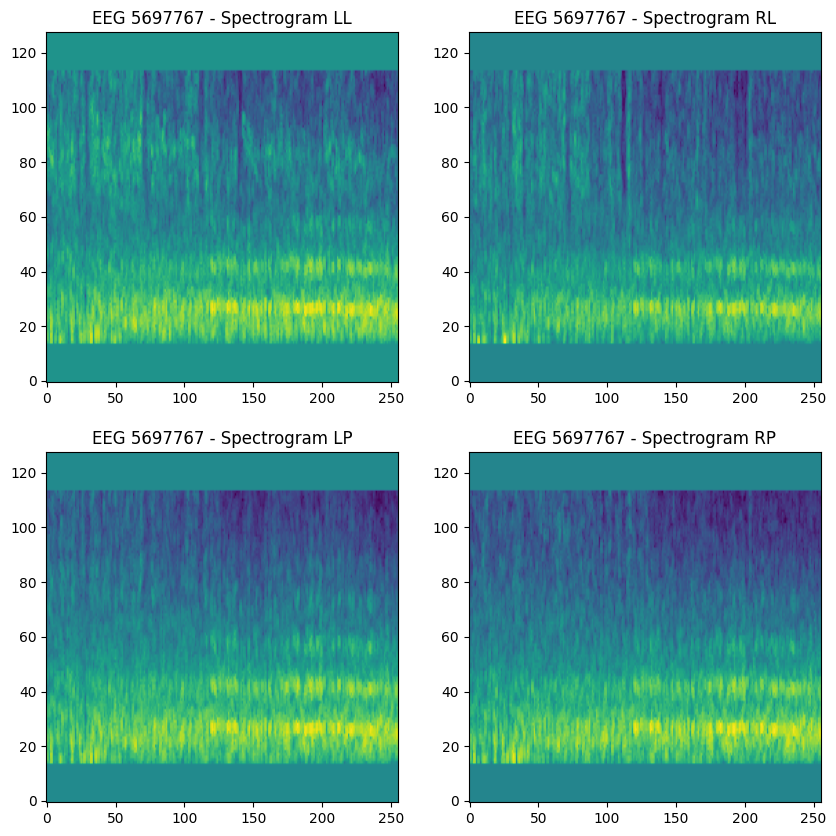

In [28]:
process_kaggle_spec(
    os.path.join(DATA_ROOT, f"train_spectrograms_npy/train_spectrograms_npy/{aggr_train['spec_id'].iloc[aggr_train_row_id]}.h5"),
    aggr_train['middle'].iloc[aggr_train_row_id],
    display=True
);

In [29]:
def spectrogram_from_eeg(h5py_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = read_h5py_file(h5py_path)
    middle = (len(eeg[NEURAL_SENSORS[0]])-10_000)//2
    for k in NEURAL_SENSORS:
        eeg[k] = eeg[k][middle:middle+10_000]
        
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    if display: 
        plt.figure(figsize=(12,12))
    signals = []
    for k in range(4):
        COLS = REVERSED_FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]] - eeg[COLS[kk+1]]

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            # if USE_WAVELET:
            #     x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256, 
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40 
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            eeg_id = os.path.splitext(os.path.basename(h5py_path))[0]
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {REVERSED_FEATS[k]}')
    
    if display: 
        plt.show()
        plt.figure(figsize=(10,10))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=REVERSED_FEATS[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        
    return img

> <font style="color:red">**TODO**</font>: Re-write `spectrogram_from_eeg`, so it extracts only `signal` and than all specogtams are extracted using torchaudio/nnAudio. (2+ points)

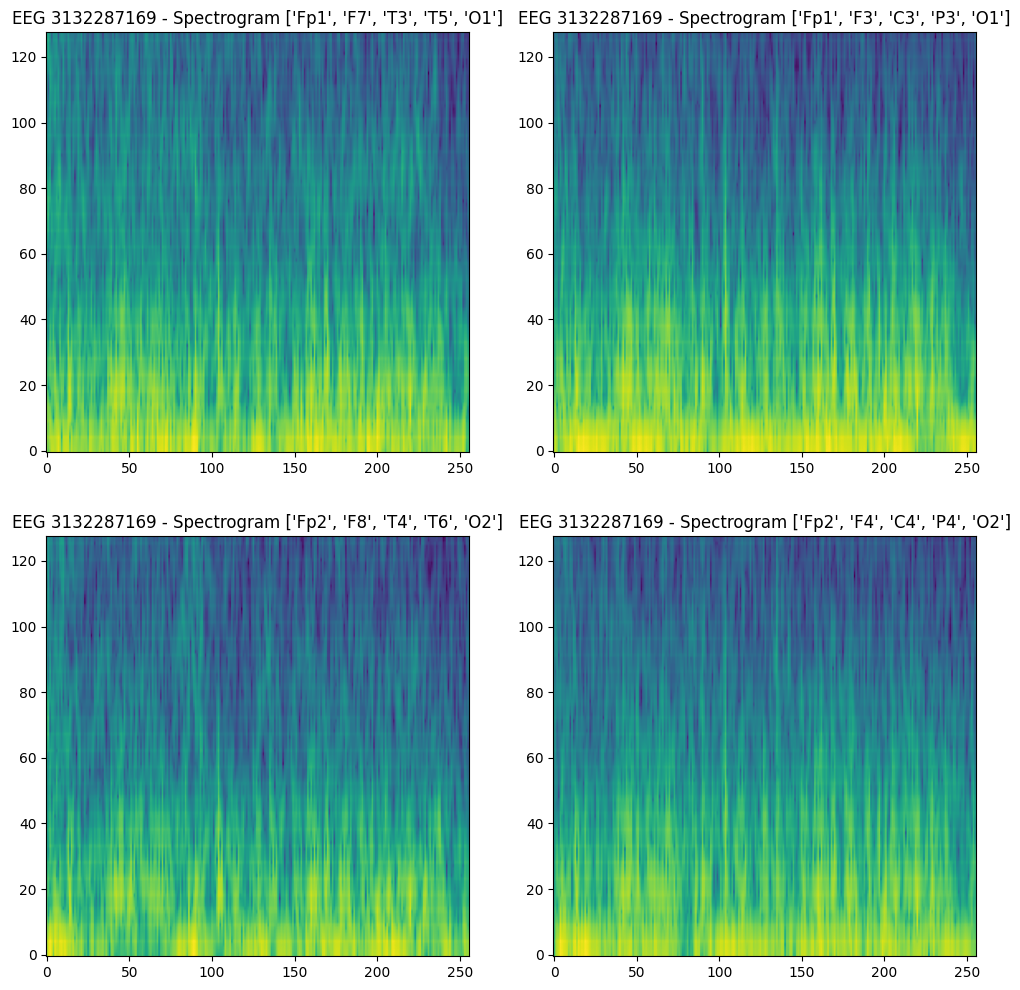

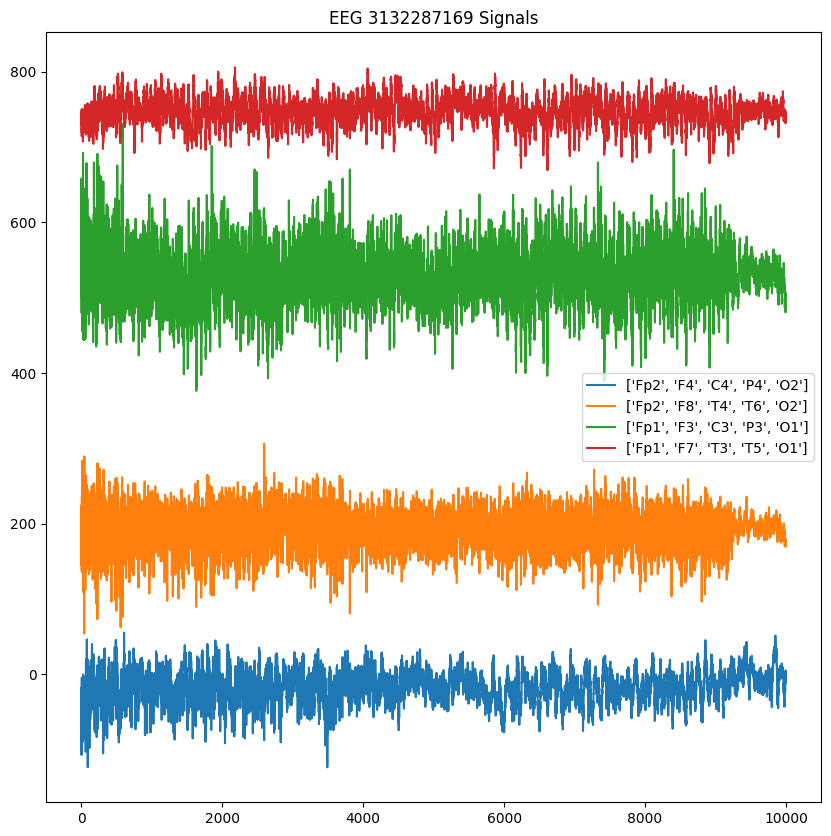

array([[[0.7295036 , 0.71416485, 0.7232692 , 0.4362474 ],
        [0.6665901 , 0.7998251 , 0.84214175, 0.7056119 ],
        [0.7567398 , 0.72912633, 0.8796954 , 0.7985978 ],
        ...,
        [0.7592336 , 0.7675753 , 0.763102  , 0.6916145 ],
        [0.5395933 , 0.8143544 , 0.7340077 , 0.6791685 ],
        [0.5714077 , 0.7914679 , 0.7383389 , 0.66555727]],

       [[0.729453  , 0.71289164, 0.7220316 , 0.4364146 ],
        [0.69268054, 0.7959461 , 0.8375374 , 0.7028499 ],
        [0.7623217 , 0.72581625, 0.87618697, 0.7951722 ],
        ...,
        [0.7606673 , 0.77272916, 0.76216835, 0.6852364 ],
        [0.5640659 , 0.810534  , 0.7306627 , 0.67529136],
        [0.5713591 , 0.7876175 , 0.73416674, 0.66133356]],

       [[0.7293401 , 0.71122503, 0.72041607, 0.4365306 ],
        [0.7070061 , 0.7908747 , 0.831476  , 0.6992805 ],
        [0.7670158 , 0.72148913, 0.87160397, 0.7906776 ],
        ...,
        [0.7617842 , 0.77660084, 0.76081824, 0.676641  ],
        [0.5780238 , 0.805538

In [30]:
spectrogram_from_eeg(
    os.path.join(DATA_ROOT, f"train_eegs_npy/train_eegs_npy/{aggr_train['eeg_id'].iloc[aggr_train_row_id]}.h5"),
    display=True
)

In [31]:
def spectrogram_from_eeg_and_save(eeg_src_path, eeg_tgt_path):
    
    img = spectrogram_from_eeg(eeg_src_path, display=False)

    with h5py.File(eeg_tgt_path, "w") as data_file:
        for i, spec_type in enumerate(REVERSED_SPEC_TYPES):
            data_file.create_dataset(spec_type, data=img[:,:,i]) 

In [32]:
# eeg_file_pathes = glob(
#     os.path.join(DATA_ROOT,"train_eegs_npy/*.h5")
# )
# print(f"Found {len(eeg_file_pathes)} EEG files")

# os.makedirs(
#     os.path.join(DATA_ROOT,"train_spectrograms_reversed_npy"), exist_ok=True
# )
# ProgressParallel(n_jobs=4, total=len(eeg_file_pathes))(
#     delayed(spectrogram_from_eeg_and_save)(
#         eeg_src_path=eeg_src_path,
#         eeg_tgt_path=eeg_src_path.replace("train_eegs_npy", "train_spectrograms_reversed_npy")
#     )
#     for eeg_src_path in eeg_file_pathes
# );

In [33]:
def visualise_eeg_specs(input_df, prefix=""):
    plt.figure(figsize=(12,12))
    for k, (feat_name, array) in enumerate(input_df.items()):
        plt.subplot(2,2,k+1)
        plt.imshow(array, aspect='auto', origin='lower')
        plt.title(f'EEG {prefix} - Spectrogram {feat_name}')

In [34]:
sample_eeg_spec = read_h5py_file(os.path.join(DATA_ROOT, f"train_spectrograms_reversed_npy/train_spectrograms_reversed_npy/{aggr_train['eeg_id'].iloc[aggr_train_row_id]}.h5"))

In [35]:
sample_eeg_spec

{'LL': array([[0.7295035 , 0.66659003, 0.7567397 , ..., 0.7592335 , 0.5395932 ,
         0.5714076 ],
        [0.7294529 , 0.69268054, 0.76232165, ..., 0.7606672 , 0.5640659 ,
         0.57135904],
        [0.72934   , 0.70700604, 0.7670158 , ..., 0.7617841 , 0.57802373,
         0.5708993 ],
        ...,
        [0.46397537, 0.5099935 , 0.4025605 , ..., 0.05728309, 0.08309948,
         0.02331068],
        [0.43885568, 0.4767833 , 0.39387473, ..., 0.01765232, 0.0414326 ,
         0.00962409],
        [0.43559793, 0.4679219 , 0.39970127, ..., 0.03529097, 0.02435302,
         0.01098516]], dtype=float32),
 'LP': array([[0.7141648 , 0.799825  , 0.72912633, ..., 0.76757526, 0.8143543 ,
         0.7914678 ],
        [0.7128916 , 0.79594606, 0.72581613, ..., 0.7727291 , 0.810534  ,
         0.7876175 ],
        [0.7112249 , 0.7908747 , 0.72148895, ..., 0.77660084, 0.8055389 ,
         0.7825367 ],
        ...,
        [0.11327481, 0.26269844, 0.25547272, ..., 0.09205842, 0.05704665,
       

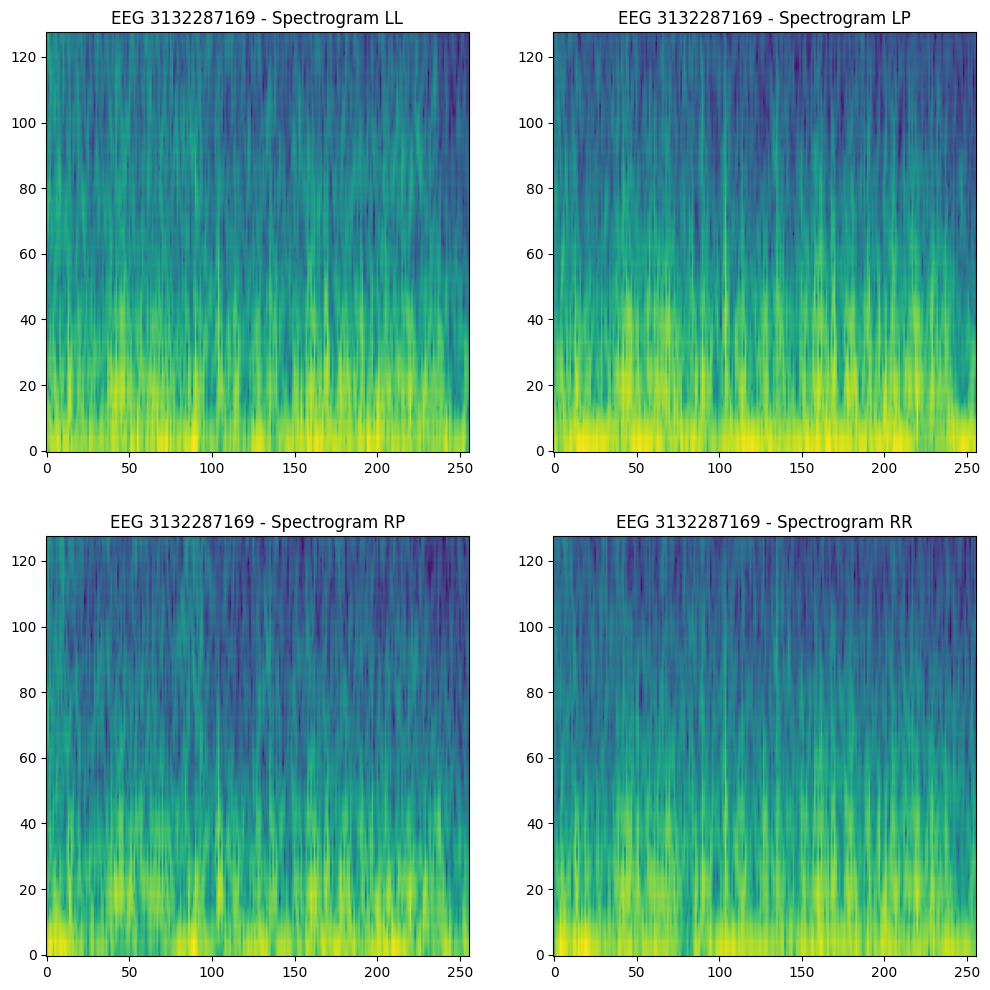

In [36]:
visualise_eeg_specs(sample_eeg_spec, aggr_train['eeg_id'].iloc[aggr_train_row_id])

> <font style="color:red">**TODO**</font>: Explain why such "aggregated" approach leads to better LB score. (1+ points)

<a id='Validation'></a>
# Validation

In [37]:
split = list(StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42).split(
    aggr_train,
    aggr_train["target"], 
    aggr_train["patient_id"]
))
split

[(array([    0,     2,     3, ..., 17086, 17087, 17088]),
  array([    1,     9,    14, ..., 17060, 17074, 17077])),
 (array([    0,     1,     2, ..., 17084, 17086, 17087]),
  array([    4,     6,     7, ..., 17083, 17085, 17088])),
 (array([    1,     2,     4, ..., 17086, 17087, 17088]),
  array([    0,     3,     5, ..., 17080, 17081, 17082])),
 (array([    0,     1,     3, ..., 17085, 17086, 17088]),
  array([    2,    10,    11, ..., 17075, 17084, 17087])),
 (array([    0,     1,     2, ..., 17085, 17087, 17088]),
  array([    8,    15,    20, ..., 17078, 17079, 17086]))]

In [38]:
for train_idx, val_idx in split:
    assert not set(aggr_train.iloc[train_idx].index) & set(aggr_train.iloc[val_idx].index)
    assert not set(aggr_train.iloc[train_idx].patient_id) & set(aggr_train.iloc[val_idx].patient_id)

In [39]:
split = np.array(split, dtype=object)
# np.save(os.path.join(DATA_ROOT, "cv_split_v1.npy"), split)

<a id='Code_Preparation'></a>
# Code Preparation

In this part, we will prepare all Modules needed for future training:

- Dataset.
- Loss.
- [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html).
- Callbacks.

## [Dataset and Dataloader](https://pytorch.org/docs/stable/data.html)

In [40]:
class CombinedDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        root_eeg,
        root_spec,
        df,
        target_col="target",
        target_cols=None,
        spec_id_col="spec_id",
        eeg_id_col="eeg_id",
        middle_second_col="middle",
        transform=None,
        test_mode=False,
        specs_to_use="all"
    ):
        assert specs_to_use in ["all", "eeg_spec", "original_spec"]
        
        self.df = df.reset_index(drop=True)

        self.target_col = target_col
        if target_cols is None:
            self.target_cols = [el.lower() + "_vote" for el in TARGETS]
        else:
            self.target_cols = target_cols
        self.name_col = spec_id_col
        self.eeg_id_col = eeg_id_col
        self.test_mode = test_mode
        self.middle_second_col = middle_second_col
        self.specs_to_use = specs_to_use

        self.root_eeg = root_eeg
        self.root_spec = root_spec

        self.transform = transform

    def __len__(self):
        return len(self.df)

    def _prepare_sample(
        self,
        spec_id,
        eeg_id,
        middle
    ):
        eeg_path = os.path.join(self.root_eeg, f"{eeg_id}.h5")
        spec_path = os.path.join(self.root_spec, f"{spec_id}.h5")
        middle = int(middle)

        if self.specs_to_use == "all":
            n_specs = 8
        else:
            n_specs = 4
        
        X = np.zeros((128, 256, n_specs),dtype='float32')

        if self.specs_to_use in ["all", "original_spec"]:
            specs = read_h5py_file(spec_path)

            for k_id, k in enumerate(SPEC_TYPES):
                # EXTRACT 300 ROWS OF SPECTROGRAM
                # import ipdb; ipdb.set_trace()
                img = specs[k][:, middle:middle+300]
                
                # LOG TRANSFORM SPECTROGRAM
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)
                
                # STANDARDIZE PER IMAGE
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img - m) / (s + ep)
                img = np.nan_to_num(img, nan=0.0)
                
                # CROP TO 256 TIME STEPS
                X[14:-14, :, k_id] = img[:, 22:-22] / 2.0

        if self.specs_to_use in ["all", "eeg_spec"]:
            eeg_spec = read_h5py_file(eeg_path)

            if self.specs_to_use == "all":
                X[:, :, 4:] = np.stack([
                    eeg_spec[k] for k in REVERSED_SPEC_TYPES
                ], axis=-1)
            else:
                X[:, :, :] = np.stack([
                    eeg_spec[k] for k in REVERSED_SPEC_TYPES
                ], axis=-1)

        
        return X

    def __getitem__(self, idx: int):
        middle_second = self.df[self.middle_second_col].iloc[idx]
        eeg_id = self.df[self.eeg_id_col].iloc[idx]
        spec_id = self.df[self.name_col].iloc[idx]

        if self.test_mode:
            main_target = -1
            all_targets = np.full(len(self.target_cols), -1.0)
        else:
            main_target = self.df[self.target_col].iloc[idx]
            main_target = TARGET2ID[main_target]
            all_targets = self.df[self.target_cols].iloc[idx].values

        all_targets = torch.from_numpy(all_targets.astype(np.float32))
        main_target = torch.tensor(main_target).long()
        specs = self._prepare_sample(
            spec_id=spec_id,
            eeg_id=eeg_id,
            middle=middle_second
        )

        if self.transform is not None:
            specs = self.transform(image=specs)["image"]

        specs = specs.float()

        return specs, main_target, all_targets, eeg_id

> **TODO**: Implement MixUp and try other augmentations.

In [41]:
testing_dataset = CombinedDataset(
    root_eeg=os.path.join(DATA_ROOT, "train_spectrograms_reversed_npy/train_spectrograms_reversed_npy"),
    root_spec=os.path.join(DATA_ROOT, "train_spectrograms_npy/train_spectrograms_npy"),
    df=aggr_train,
    transform=A.Compose([
        ToTensorV2(transpose_mask=True),
    ]),
)

In [42]:
testing_dataset[0]

(tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,

In [43]:
testing_specs, testing_main_target, testing_all_targets, testing_eeg_id = testing_dataset[120]

print("Main target", testing_main_target)
print("All targets", testing_all_targets)
print("EEG Id", testing_eeg_id)

print("Shape", testing_specs.shape)

Main target tensor(5)
All targets tensor([0.0000, 0.0000, 0.1429, 0.0000, 0.1429, 0.7143])
EEG Id 30965526
Shape torch.Size([8, 128, 256])


In [44]:
testing_dataloader = torch.utils.data.DataLoader(
    testing_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True
)
for batch in testing_dataloader:
    break
    
print(
    "Spec Batch Shape:", batch[0].shape,
    "\nMain Target Batch Shape:", batch[1].shape,
    "\nAll Target Batch Shape:", batch[2].shape,
    "\nEEG IDs Batch Shape:", batch[3].shape,
)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Spec Batch Shape: torch.Size([16, 8, 128, 256]) 
Main Target Batch Shape: torch.Size([16]) 
All Target Batch Shape: torch.Size([16, 6]) 
EEG IDs Batch Shape: torch.Size([16])


## Loss

We will use a wrapper on top of [KLDivLoss](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html).

In [45]:
class TorchKLDivergenceLoss(nn.Module):
    def __init__(
        self, 
        epsilon=1e-6,
    ):
        super(TorchKLDivergenceLoss, self).__init__()
        self.epsilon = epsilon
        self.kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)

    def forward(self, y_pred_, y_true_):
        y_true_ = y_true_ + self.epsilon
        y_true_ = torch.log(y_true_ / y_true_.sum(dim=1, keepdim=True))
        y_pred_ = F.log_softmax(y_pred_, dim=1)

        return self.kl_loss(y_pred_, y_true_)

In [46]:
sample_target_batch = batch[2]
sample_target_batch

tensor([[0.0000, 0.0000, 0.3333, 0.0000, 0.0833, 0.5833],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1765, 0.0000, 0.0000, 0.8235],
        [0.0000, 0.2000, 0.0667, 0.0000, 0.0000, 0.7333],
        [0.0000, 0.0000, 0.3636, 0.0000, 0.1818, 0.4545],
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.5000, 0.0000, 0.1111, 0.3889],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1875, 0.2500, 0.5625],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000]])

In [47]:
sample_pred_batch = torch.randn_like(sample_target_batch)
sample_pred_batch

tensor([[ 0.9150, -0.3929,  0.2643,  0.2764, -0.0028,  0.0054],
        [-1.4849, -0.6007, -0.4227,  0.5122, -1.4023,  0.7801],
        [ 0.7584,  0.7574, -1.0869, -0.3298,  0.6154,  0.2304],
        [ 0.0655, -0.6876,  0.8723,  0.6856,  1.7613,  1.8633],
        [-0.4706,  2.3355,  1.2844, -0.2787, -1.5167,  0.5986],
        [-0.5178,  0.3816,  0.7889, -0.3005, -0.3364,  1.1683],
        [-0.5720,  1.0730, -0.7247, -0.4502, -1.1737, -2.7219],
        [-0.0833,  0.3830,  0.1037,  0.8687,  2.2715, -2.0254],
        [-0.1786, -0.9837,  0.5649, -0.9611, -0.4987, -0.5392],
        [ 0.7382, -1.1786, -0.5709,  0.1560,  0.8977,  0.7478],
        [-1.3672, -0.9831, -1.1596,  0.9517,  0.1497,  1.6448],
        [-0.5209,  0.7685, -1.1236,  0.7015,  0.4482, -0.7349],
        [-0.6135, -1.1055, -0.6051, -2.1480,  0.8532,  0.2686],
        [-1.9414,  0.3062, -0.2649, -0.2068, -0.3789, -1.4583],
        [-0.5952, -1.3722,  0.6507,  0.2025, -2.0899,  0.9299],
        [-2.1128,  0.7325,  0.4324,  0.5

In [48]:
loss_func = TorchKLDivergenceLoss()
print("Random Prediction:", loss_func(
        sample_pred_batch, sample_target_batch
    )
)

Random Prediction: tensor(1.8391)


> **TODO**: Try other losses

## [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html)

In [49]:
class LitTrainer(lightning.LightningModule):
    def __init__(
        self,
        model,
        forward,
        optimizer,
        scheduler,
        scheduler_params,
        batch_key,
    ):
        super().__init__()

        self.model = model
        self._forward = forward
        self._optimizer = optimizer
        self._scheduler = scheduler
        self._scheduler_params = scheduler_params
        self._batch_key = batch_key

    def _aggregate_outputs(self, losses, inputs, outputs):
        united = losses
        united.update({"input_" + k: v for k, v in inputs.items()})
        united.update({"output_" + k: v for k, v in outputs.items()})
        return united

    def training_step(self, batch):

        start_time = time()
        losses, inputs, outputs = self._forward(self, batch, epoch=self.current_epoch)
        model_time = time() - start_time

        for k, v in losses.items():
            self.log(
                "train_" + k,
                v,
                on_step=True,
                on_epoch=False,
                prog_bar=True,
                logger=True,
                batch_size=inputs[self._batch_key].shape[0],
                sync_dist=True,
            )
            self.log(
                "train_avg_" + k,
                v,
                on_step=False,
                on_epoch=True,
                prog_bar=True,
                logger=True,
                batch_size=inputs[self._batch_key].shape[0],
                sync_dist=True,
            )
        self.log(
            "train_model_time",
            model_time,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
            batch_size=1,
            sync_dist=True,
        )
        self.log(
            "train_avg_model_time",
            model_time,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            batch_size=1,
            sync_dist=True,
        )

        return self._aggregate_outputs(losses, inputs, outputs)

    def validation_step(self, batch, batch_idx):

        start_time = time()
        losses, inputs, outputs = self._forward(self, batch, epoch=self.current_epoch)
        model_time = time() - start_time

        for k, v in losses.items():
            self.log(
                "valid_" + k,
                v,
                on_step=True,
                on_epoch=False,
                prog_bar=True,
                logger=True,
                batch_size=inputs[self._batch_key].shape[0],
                sync_dist=True,
            )
            self.log(
                "valid_avg_" + k,
                v,
                on_step=False,
                on_epoch=True,
                prog_bar=True,
                logger=True,
                batch_size=inputs[self._batch_key].shape[0],
                sync_dist=True,
            )
        self.log(
            "valid_model_time",
            model_time,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
            batch_size=1,
            sync_dist=True,
        )
        self.log(
            "valid_avg_model_time",
            model_time,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
            batch_size=1,
            sync_dist=True,
        )

        return self._aggregate_outputs(losses, inputs, outputs)

    def configure_optimizers(self):
        scheduler = {"scheduler": self._scheduler}
        scheduler.update(self._scheduler_params)
        return (
            [self._optimizer],
            [scheduler],
        )

In [50]:
class MultilabelSpecClsForward(nn.Module):
    def __init__(
        self,
        loss_function,
        output_key="logits",
        input_key="all_targets",
    ):
        super().__init__()
        self.loss_function = loss_function
        self.output_key = output_key
        self.input_key = input_key

    def forward(self, runner, batch, epoch=None):

        specs, main_target, all_targets, _ = batch

        output = runner.model(specs)

        inputs = {
            "specs": specs,
            "main_target": main_target,
            "all_targets": all_targets,
        }

        losses = {
            "loss": self.loss_function(
                output[self.output_key],
                inputs[self.input_key],
            )
        }

        return losses, inputs, output

## [Callbacks](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html)

In [51]:
class KLCallback(Callback):
    def __init__(
        self,
        pred_key: str = "preds",
        gt_label_key: str = "all_targets",
        loader_names: Tuple = ("valid"),
        verbose: bool = False,
    ):
        self.pred_key = pred_key
        self.gt_label_key = gt_label_key
        self.loader_names = loader_names
        self.accums = {
            loader_name: {
                "preds": [],
                "gt_labels": [],
            }
            for loader_name in loader_names
        }
        self.verbose = verbose

    def initialize_accums(self, loader_name):
        self.accums[loader_name] = {
            "preds": [],
            "gt_labels": [],
        }

    def update_accums(self, outputs, loader_name):
        pred = outputs["output_" + self.pred_key].detach()
        pred = torch.softmax(pred, dim=1)
        pred = pred.cpu().numpy()

        gt_label = outputs["input_" + self.gt_label_key].detach()
        gt_label = gt_label.cpu().numpy()

        self.accums[loader_name]["preds"].append(pred)
        self.accums[loader_name]["gt_labels"].append(gt_label)

    def compute_kl(self, pl_module, loader_name):
        preds = np.concatenate(self.accums[loader_name]["preds"], axis=0) 
        gt_labels = np.concatenate(self.accums[loader_name]["gt_labels"], axis=0)
        gt_labels = gt_labels / gt_labels.sum(axis=1, keepdims=True)

        kl = numpy_kl_divergence(
            y_true=gt_labels,
            y_pred=preds,
            micro_average=True,
        )

        pl_module.log(
            loader_name + "_kl",
            kl,
        )

    def on_train_epoch_start(self, trainer, pl_module):
        if "train" in self.loader_names:
            self.initialize_accums("train")

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        if "train" in self.loader_names:
            self.update_accums(outputs, "train")

    def on_train_epoch_end(self, trainer, pl_module):
        if "train" in self.loader_names:
            self.compute_kl(pl_module, "train")
            self.initialize_accums("train")

    def on_validation_epoch_start(self, trainer, pl_module):
        if "valid" in self.loader_names:
            self.initialize_accums("valid")

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        if "valid" in self.loader_names:
            self.update_accums(outputs, "valid")

    def on_validation_epoch_end(self, trainer, pl_module):
        if "valid" in self.loader_names:
            self.compute_kl(pl_module, "valid")
            self.initialize_accums("valid")

<a id='Model'></a>
# Model

We will use CNN based approach and build next Pipeline:
1. Normalization Layer.
2. (Optional) Augmentation Layer.
3. CNN Encoder.
4. Pooling Layer.
5. Classification Layer.

Something near the architecture, which I have used on [BirdCLEF 2023](https://www.kaggle.com/competitions/birdclef-2023/discussion/412808).

![nn_arch](images/nn_arch.png)

As CNN backbone we will use [EfficientNet](https://arxiv.org/abs/1905.11946) family with pretrains from [timm repo](https://github.com/huggingface/pytorch-image-models).

> **TODO**: Try other CNN architecture "families".

In [ ]:
# backbone_architecture = "tf_efficientnet_b0.in1k"
backbone_architecture = "resnet18.a1_in1k"

In [52]:
class NormalizeMelSpec(nn.Module):
    def __init__(
        self,
        eps=1e-6,
        normalize_standart=True,
        normalize_minmax=True,
    ):
        super().__init__()
        self.eps = eps
        self.normalize_standart = normalize_standart
        self.normalize_minmax = normalize_minmax

    def forward(self, X):
        if self.normalize_standart:
            mean = X.mean((2, 3), keepdim=True)
            std = X.std((2, 3), keepdim=True)
            X = (X - mean) / (std + self.eps)
            
        if self.normalize_minmax:
            norm_max = torch.amax(X, dim=(2, 3), keepdim=True)
            norm_min = torch.amin(X, dim=(2, 3), keepdim=True)
            X = (X - norm_min) / (norm_max - norm_min + self.eps)

        return X

class CustomMasking(nn.Module):
    def __init__(self, mask_max_length: int, mask_max_masks: int, p=1.0, inplace=True):
        super().__init__()
        assert isinstance(mask_max_masks, int) and mask_max_masks > 0
        self.mask_max_masks = mask_max_masks
        self.mask_max_length = mask_max_length
        self.mask_module = None
        self.p = p
        self.inplace = inplace

    def forward(self, x):
        if not self.inplace:
            output = x.clone()
        for i in range(x.shape[0]):
            if np.random.binomial(n=1, p=self.p):
                n_applies = np.random.randint(low=1, high=self.mask_max_masks + 1)
                for _ in range(n_applies):
                    if self.inplace:
                        x[i : i + 1] = self.mask_module(x[i : i + 1])
                    else:
                        output[i : i + 1] = self.mask_module(output[i : i + 1])
        if self.inplace:
            return x
        else:
            return output


class CustomTimeMasking(CustomMasking):
    def __init__(self, mask_max_length: int, mask_max_masks: int, p=1.0, inplace=True):
        super().__init__(mask_max_length=mask_max_length, mask_max_masks=mask_max_masks, p=p, inplace=inplace)
        self.mask_module = TimeMasking(time_mask_param=mask_max_length)


class CustomFreqMasking(CustomMasking):
    def __init__(self, mask_max_length: int, mask_max_masks: int, p=1.0, inplace=True):
        super().__init__(mask_max_length=mask_max_length, mask_max_masks=mask_max_masks, p=p, inplace=inplace)
        self.mask_module = FrequencyMasking(freq_mask_param=mask_max_length)

class SpecCNNClasifier(nn.Module):
    def __init__(
        self,
        backbone: str,
        device: str,
        n_specs: int,
        n_classes: int,
        classifier_dropout: float = 0.5,
        normalize_config: Dict[str, bool] = {
            "normalize_standart": True,
            "normalize_minmax": True,
        },
        pretrained: bool = True,
        timm_kwargs: Optional[Dict] = None,
        spec_augment_config: Optional[Dict[str, Any]] = None,
    ):
        super().__init__()
        timm_kwargs = {} if timm_kwargs is None else timm_kwargs
        self.device = device

        self.instance_norm = NormalizeMelSpec(
            **normalize_config
        )
        
        if spec_augment_config is not None:
            self.spec_augment = []
            if "freq_mask" in spec_augment_config:
                self.spec_augment.append(CustomFreqMasking(**spec_augment_config["freq_mask"]))
            if "time_mask" in spec_augment_config:
                self.spec_augment.append(CustomTimeMasking(**spec_augment_config["time_mask"]))
            self.spec_augment = nn.Sequential(*self.spec_augment)
        else:
            self.spec_augment = None

        
        self.backbone = timm.create_model(
            backbone,
            features_only=True,
            pretrained=pretrained,
            in_chans=n_specs,
            exportable=True,
            **timm_kwargs,
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(p=classifier_dropout),
            nn.Linear(self.backbone.feature_info.channels()[-1], n_classes),
        )
        
        self.to(self.device)

    def forward(self, input, return_spec_feature=False, return_cnn_emb=False):
        processed_spec = self.instance_norm(input)
        if self.spec_augment is not None and self.training:
            processed_spec = self.spec_augment(processed_spec)
        if return_spec_feature:
            return processed_spec
            
        emb = self.backbone(processed_spec)[-1]
        if return_cnn_emb:
            return emb

        bs, ch, h, w = emb.shape
        emb = self.pool(emb)
        emb = emb.view(bs, ch)

        logits = self.classifier(emb)

        return {"logits": logits}

In [55]:
testing_model = SpecCNNClasifier(
    backbone=backbone_architecture,
    device="cpu",
    n_specs=8,
    n_classes=6,
    spec_augment_config={
        "freq_mask": {
            "mask_max_length": 20,
            "mask_max_masks": 5,
            "p": 1.0,
            "inplace": True,
        },
        "time_mask": {
            "mask_max_length": 30,
            "mask_max_masks": 5,
            "p": 1.0,
            "inplace": True,
        },
    }
)

<a id='Training'></a>
# Training

In [59]:
def lightning_training(
    train_df: Optional[pd.DataFrame],
    val_df: Optional[pd.DataFrame],
    exp_name: str,
    fold_id: Optional[int],
    forward_batch_key: str,
    train_dataset_class: torch.utils.data.Dataset,
    val_dataset_class: Optional[torch.utils.data.Dataset],
    train_dataset_config: dict,
    val_dataset_config: Optional[dict],
    train_dataloader_config: dict,
    val_dataloader_config: Optional[dict],
    nn_model_class: torch.nn.Module,
    nn_model_config: dict,
    optimizer_init: Callable,
    scheduler_init: Callable,
    scheduler_params: dict,
    forward: Union[torch.nn.Module, Callable],
    # It is not really Callable. It just lambda that will init List of callbacks
    # each time. It is just done for safe CV training.
    callbacks: Optional[Callable],
    n_epochs: int,
    main_metric: str,
    metric_mode: str,
    checkpoint_callback_params: dict = {},
    tensorboard_logger_params: dict = {},
    trainer_params: dict = {},
    precision_mode: str = "32-true",
    n_checkpoints_to_save: int = 3,
    log_every_n_steps: int = 100,
    train_strategy: str = "auto",
):
    # Set device
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Training Device : {device}")

    train_dataset = train_dataset_class(
        df=train_df,
        **train_dataset_config,
    )
    val_dataset = val_dataset_class(
        df=val_df,
        **val_dataset_config,
    )

    loaders = {
        "train": torch.utils.data.DataLoader(
            train_dataset,
            **train_dataloader_config,
        ),
        "valid": torch.utils.data.DataLoader(
            val_dataset, 
            **val_dataloader_config
        )
    }

    model = nn_model_class(device=device, **nn_model_config)

    for k in loaders.keys():
        print(f"{k} Loader Len = {len(loaders[k])}")

    optimizer = optimizer_init(model)
    scheduler = scheduler_init(optimizer, len(loaders["train"]))

    if not isinstance(forward, torch.nn.Module):
        forward = forward()

    lightning_model = LitTrainer(
        model,
        forward=forward,
        optimizer=optimizer,
        scheduler=scheduler,
        scheduler_params=scheduler_params,
        batch_key=forward_batch_key
    )

    all_callbacks = [
        ModelCheckpoint(
            dirpath=os.path.join(exp_name, "checkpoints"),
            save_top_k=n_checkpoints_to_save,
            mode=metric_mode,
            monitor=main_metric,
            **checkpoint_callback_params,
        ),
        LearningRateMonitor(logging_interval="step"),
    ]
    if callbacks is not None:
        all_callbacks += callbacks()

    tensorboard_logger = pl_loggers.TensorBoardLogger(
        save_dir=os.path.join(exp_name, "tensorboard"),
        **tensorboard_logger_params,
    )
    trainer = lightning.Trainer(
#         devices=-1,
        precision=precision_mode,
        strategy=train_strategy,
        max_epochs=n_epochs,
        logger=tensorboard_logger,
        log_every_n_steps=log_every_n_steps,
        callbacks=all_callbacks,
        **trainer_params,
    )
    trainer.fit(model=lightning_model, train_dataloaders=loaders["train"], val_dataloaders=loaders["valid"])

In [62]:
for fold_idx in range(5):
    print(f"Start Fold {fold_idx} ...")
    lightning_training(
        train_df=aggr_train.iloc[split[fold_idx][0]],
        val_df=aggr_train.iloc[split[fold_idx][1]],
        exp_name=os.path.join("logdirs/hms_baseline", f"fold_{fold_idx}"),
        fold_id=fold_idx,
        forward_batch_key="specs",
        train_dataset_class=CombinedDataset,
        val_dataset_class=CombinedDataset,
        train_dataset_config=dict(
            root_eeg=os.path.join(DATA_ROOT, "train_spectrograms_reversed_npy/train_spectrograms_reversed_npy"),
            root_spec=os.path.join(DATA_ROOT, "train_spectrograms_npy/train_spectrograms_npy"),
            transform=A.Compose([
                ToTensorV2(transpose_mask=True),
            ]),
        ),
        val_dataset_config=dict(
            root_eeg=os.path.join(DATA_ROOT, "train_spectrograms_reversed_npy/train_spectrograms_reversed_npy"),
            root_spec=os.path.join(DATA_ROOT, "train_spectrograms_npy/train_spectrograms_npy"),
            transform=A.Compose([
                ToTensorV2(transpose_mask=True),
            ]),
        ),
        train_dataloader_config={
            "batch_size": 128,
            "shuffle": False,
            "drop_last": True,
            "num_workers": 8,
            "pin_memory": True,
        },
        val_dataloader_config={
            "batch_size": 128,
            "shuffle": False,
            "drop_last": False,
            "num_workers": 8,
            "pin_memory": True,
        },
        nn_model_class=predicted_df.to_csv('submission.csv', index=False),
        nn_model_config=dict(
            backbone=backbone_architecture,
            n_specs=8,
            n_classes=6,
            spec_augment_config={
                "freq_mask": {
                    "mask_max_length": 20,
                    "mask_max_masks": 5,
                    "p": 1.0,
                    "inplace": True,
                },
                "time_mask": {
                    "mask_max_length": 30,
                    "mask_max_masks": 5,
                    "p": 1.0,
                    "inplace": True,
                },
            }
        ),
        optimizer_init=lambda model: torch.optim.Adam(model.parameters(), lr=1e-3),
        scheduler_init=lambda optimizer, len_train: torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            eta_min=1e-6,
            T_max=len_train * 12,
        ),
        scheduler_params={"interval": "step", "monitor": "valid_kl"},
        forward=lambda: MultilabelSpecClsForward(
            TorchKLDivergenceLoss(),
            input_key="all_targets",
            output_key="logits",
        ),
        callbacks=lambda: [
            KLCallback(
                pred_key="logits",
                gt_label_key="all_targets",
                loader_names=("valid", "train"),
                verbose=True,
            )
        ],
        n_epochs=4,
        main_metric="valid_kl",
        metric_mode="min",
        checkpoint_callback_params=dict(
            save_last=True,
            auto_insert_metric_name=True,
            save_weights_only=True,
            save_on_train_epoch_end=True,
            filename="{epoch}-{step}-{valid_kl:.3f}",
        ),
        precision_mode="32",
    )
    print(f"End Fold {fold_idx}!")

Start Fold 0 ...
Training Device : cuda


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name     | Type                     | Params
------------------------------------------------------
0 | model    | SpecCNNClasifier         | 3.6 M 
1 | _forward | MultilabelSpecClsForward | 0     
------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.395    Total estimated model params size (MB)


train Loader Len = 107
valid Loader Len = 27


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.


End Fold 0!
Start Fold 1 ...
Training Device : cuda


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name     | Type                     | Params
------------------------------------------------------
0 | model    | SpecCNNClasifier         | 3.6 M 
1 | _forward | MultilabelSpecClsForward | 0     
------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.395    Total estimated model params size (MB)


train Loader Len = 102
valid Loader Len = 31


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.


End Fold 1!
Start Fold 2 ...
Training Device : cuda


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name     | Type                     | Params
------------------------------------------------------
0 | model    | SpecCNNClasifier         | 3.6 M 
1 | _forward | MultilabelSpecClsForward | 0     
------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.395    Total estimated model params size (MB)


train Loader Len = 104
valid Loader Len = 29


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.


End Fold 2!
Start Fold 3 ...
Training Device : cuda


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name     | Type                     | Params
------------------------------------------------------
0 | model    | SpecCNNClasifier         | 3.6 M 
1 | _forward | MultilabelSpecClsForward | 0     
------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.395    Total estimated model params size (MB)


train Loader Len = 112
valid Loader Len = 22


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.


End Fold 3!
Start Fold 4 ...
Training Device : cuda


INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name     | Type                     | Params
------------------------------------------------------
0 | model    | SpecCNNClasifier         | 3.6 M 
1 | _forward | MultilabelSpecClsForward | 0     
------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.395    Total estimated model params size (MB)


train Loader Len = 106
valid Loader Len = 27


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.


End Fold 4!


In [63]:
!ls logdirs/hms_baseline/

fold_0	fold_1	fold_2	fold_3	fold_4


In [64]:
!ls logdirs/hms_baseline/fold_0/

checkpoints  tensorboard


In [65]:
!ls logdirs/hms_baseline/fold_0/checkpoints/

'epoch=1-step=214-valid_kl=0.745.ckpt'	'epoch=3-step=428-valid_kl=0.685.ckpt'
'epoch=2-step=321-valid_kl=0.708.ckpt'	 last.ckpt


<a id='Evaluation'></a>
# Evaluation

## Preparation for inference

In [66]:
val_dfs = [
    aggr_train.iloc[split[fold_idx][1]] for fold_idx in range(5)
]

In [67]:
val_datasets = [
    CombinedDataset(
        root_eeg=os.path.join(DATA_ROOT, "train_spectrograms_reversed_npy/train_spectrograms_reversed_npy"),
        root_spec=os.path.join(DATA_ROOT, "train_spectrograms_npy/train_spectrograms_npy"),
        test_mode=True,
        transform=A.Compose([
            ToTensorV2(transpose_mask=True),
        ]),
        df=val_df
    )
    for val_df in val_dfs
]

In [68]:
val_dataloaders = [
    torch.utils.data.DataLoader(
        dataset,
        batch_size=64,
        drop_last=False,
        shuffle=False,
        num_workers=4
    )
    for dataset in val_datasets
]

In [69]:
def delete_prefix_from_chkp(chkp_dict: OrderedDict, prefix: str):
    new_dict = OrderedDict()
    for k in chkp_dict.keys():
        if k.startswith(prefix):
            new_dict[k[len(prefix) :]] = chkp_dict[k]
        else:
            new_dict[k] = chkp_dict[k]

    return new_dict

def create_model_and_load_best_checkpoint(
    model_class,
    model_config,
    model_device,
    model_chkp_root,
    model_chkp_regex,
    sort_rule,
    delete_prefix=None,
):
    basenames = os.listdir(model_chkp_root)
    checkpoints = []
    for el in basenames:
        matches = re.findall(model_chkp_regex, el)
        if not matches:
            continue
        parsed_dict = {key: value for key, value in matches}
        parsed_dict["name"] = el
        checkpoints.append(parsed_dict)
    print("All checkpoints")
    pprint(checkpoints)
    checkpoints = sorted(checkpoints, key=sort_rule)
    print("Sorted checkpoints")
    pprint(checkpoints)
    best_checkpoint = os.path.join(model_chkp_root, checkpoints[0]["name"])
    print("Best checkpoint")
    print(best_checkpoint)
    t_chkp = torch.load(
        best_checkpoint, 
        map_location="cpu"
    )["state_dict"]
    if delete_prefix is not None:
        t_chkp = delete_prefix_from_chkp(t_chkp, delete_prefix)
    t_model = model_class(**model_config, device=model_device)
    t_model.load_state_dict(t_chkp)
    t_model.eval()

    return t_model

In [70]:
model = [create_model_and_load_best_checkpoint(
        model_class=SpecCNNClasifier,
        model_config=dict(
            backbone=backbone_architecture,
            n_specs=8,
            n_classes=6,
            spec_augment_config={
                "freq_mask": {
                    "mask_max_length": 20,
                    "mask_max_masks": 5,
                    "p": 1.0,
                    "inplace": True,
                },
                "time_mask": {
                    "mask_max_length": 30,
                    "mask_max_masks": 5,
                    "p": 1.0,
                    "inplace": True,
                },
            }
        ),
        model_device="cuda",
        model_chkp_root=f"logdirs/hms_baseline/fold_{m_i}/checkpoints",
        model_chkp_regex=r'(?P<key>\w+)=(?P<value>[\d.]+)(?=\.ckpt|$)',
        sort_rule=lambda x: float(x["valid_kl"]),
        delete_prefix="model."
) for m_i in range(5)]

All checkpoints
[{'name': 'epoch=2-step=321-valid_kl=0.708.ckpt', 'valid_kl': '0.708'},
 {'name': 'epoch=1-step=214-valid_kl=0.745.ckpt', 'valid_kl': '0.745'},
 {'name': 'epoch=3-step=428-valid_kl=0.685.ckpt', 'valid_kl': '0.685'}]
Sorted checkpoints
[{'name': 'epoch=3-step=428-valid_kl=0.685.ckpt', 'valid_kl': '0.685'},
 {'name': 'epoch=2-step=321-valid_kl=0.708.ckpt', 'valid_kl': '0.708'},
 {'name': 'epoch=1-step=214-valid_kl=0.745.ckpt', 'valid_kl': '0.745'}]
Best checkpoint
logdirs/hms_baseline/fold_0/checkpoints/epoch=3-step=428-valid_kl=0.685.ckpt
All checkpoints
[{'name': 'epoch=2-step=306-valid_kl=0.716.ckpt', 'valid_kl': '0.716'},
 {'name': 'epoch=1-step=204-valid_kl=0.786.ckpt', 'valid_kl': '0.786'},
 {'name': 'epoch=3-step=408-valid_kl=0.684.ckpt', 'valid_kl': '0.684'}]
Sorted checkpoints
[{'name': 'epoch=3-step=408-valid_kl=0.684.ckpt', 'valid_kl': '0.684'},
 {'name': 'epoch=2-step=306-valid_kl=0.716.ckpt', 'valid_kl': '0.716'},
 {'name': 'epoch=1-step=204-valid_kl=0.786.ck

## Run inference

In [71]:
@torch.inference_mode()
def inference_function(
    loader,
    nn_model,
    output_key,
    device
):
    predicted_df = {"eeg_id": []}
    for target in TARGETS:
        predicted_df[target.lower() + "_vote"] = []

    for batch in tqdm(loader):
        specs, _, _, eeg_id = batch
        pred_probs = nn_model(specs.to(device))[output_key]
        pred_probs = torch.softmax(pred_probs, dim=1)
        pred_probs = pred_probs.detach().cpu().numpy()
        predicted_df["eeg_id"].append(eeg_id.cpu().numpy())
        for i, target in enumerate(TARGETS):
            predicted_df[target.lower() + "_vote"].append(pred_probs[:, i])

    for key in predicted_df:
        predicted_df[key] = np.concatenate(predicted_df[key])

    predicted_df = pd.DataFrame(predicted_df)

    return predicted_df

In [72]:
all_predicted_dfs = []
for fold_idx in range(5):
    all_predicted_dfs.append(inference_function(
        loader=val_dataloaders[fold_idx],
        nn_model=model[fold_idx],
        output_key="logits",
        device="cuda"
    ))

100%|██████████| 54/54 [00:52<00:00,  1.04it/s]


## Evaluate results

In [73]:
for fold_idx in range(5):
    val_dfs[fold_idx]["fold"] = fold_idx

all_val_dfs = pd.concat(val_dfs).reset_index(drop=True)
all_predicted_dfs = pd.concat(all_predicted_dfs).reset_index(drop=True)

/tmp/ipykernel_34/3954609140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_dfs[fold_idx]["fold"] = fold_idx
/tmp/ipykernel_34/3954609140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_dfs[fold_idx]["fold"] = fold_idx
/tmp/ipykernel_34/3954609140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [74]:
assert (all_val_dfs["eeg_id"] == all_predicted_dfs["eeg_id"]).all()

In [75]:
all_val_dfs.head()

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,votes_sum,target,middle,fold
0,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.000000,0.071429,0.0,0.071429,14.0,LPD,9.0,0
1,2366870,1232582129,0.0,30.0,23633,0.0,0.333333,0.000000,0.000000,0.0,0.666667,3.0,Other,7.0,0
2,3625731,2091405434,0.0,0.0,6935,0.0,0.000000,0.000000,0.000000,1.0,0.000000,1.0,GRDA,0.0,0
3,4454049,1313185981,342.0,380.0,44475,0.0,0.000000,0.666667,0.000000,0.0,0.333333,3.0,GPD,180.0,0
4,6259482,1497099492,0.0,62.0,2659,0.0,0.000000,0.000000,0.000000,1.0,0.000000,3.0,GRDA,15.0,0


In [76]:
all_predicted_dfs.head()

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,582999,0.040563,0.301743,0.025072,0.093021,0.051987,0.487615
1,2366870,0.002315,0.027655,0.012414,0.009579,0.016605,0.931432
2,3625731,0.023544,0.126162,0.038244,0.369471,0.215373,0.227206
3,4454049,0.033681,0.394813,0.058330,0.045403,0.022865,0.444907
4,6259482,0.044757,0.070406,0.148465,0.036813,0.249719,0.449840


In [77]:
oof_score = score(
    solution=all_val_dfs[[el.lower() + "_vote" for el in TARGETS] + ["eeg_id"]].copy(),
    submission=all_predicted_dfs.copy(),
    row_id_column_name="eeg_id"
)

scores = []
for fold_idx in range(5):
    df_mask = all_val_dfs["fold"] == fold_idx
    scores.append(score(
        solution=all_val_dfs.loc[df_mask, [el.lower() + "_vote" for el in TARGETS] + ["eeg_id"]].copy(),
        submission=all_predicted_dfs[df_mask].copy(),
        row_id_column_name="eeg_id"
    ))

scores = np.array(scores)
avg_score = round(scores.mean(), 4)
std_score = round(scores.std(), 4)
min_score = round(scores.min(), 4)
max_score = round(scores.max(), 4)
score_lower_bound = np.clip(round(avg_score - 3*std_score, 4), 0, np.inf)
score_higher_bound = round(avg_score + 3*std_score, 4)
print("All Folds KL scores")
print(scores)
pprint({
    'kl_oof': oof_score,
    'kl_avg': avg_score,
    'kl_std': std_score,
    'kl_min': min_score,
    'kl_max': max_score,
    'kl_lower_bound_estimation': score_lower_bound,
    'kl_higher_bound_estimation': score_higher_bound
})

All Folds KL scores
[0.68541696 0.68428665 0.75981125 0.68518012 0.70648393]
{'kl_avg': 0.7042,
 'kl_higher_bound_estimation': 0.7912,
 'kl_lower_bound_estimation': 0.6172,
 'kl_max': 0.7598,
 'kl_min': 0.6843,
 'kl_oof': 0.7052947322673782,
 'kl_std': 0.029}


> **TODO**: Explore Model mistakes. Maybe you can find the reason for severe overfitting.

## Inference on Kaggle

As HMS is a [Code Competition](https://www.kaggle.com/docs/competitions#notebooks-only-competitions), you have to inference with the help of the [Inference Notebook](https://www.kaggle.com/code/vladimirsydor/ucu-hms-inference/notebook).

Here is our baseline LB Score: 0.52

![lb_score](images/lb_score.png)

<a id='Homework'></a>
# Homework

Theory (5 points):
- Follow links.
- Try to fill/do **TODO** comments.
- Answer theory questions in the Google Form.

Practice (10 points):

Improve HMS baseline. Some ideas to try:

- Work more with EDA. Maybe you will find important insights. Pay attention to class balance/imbalance.
- Data preparation is very specific and might be sub-optimal. Think about alternative approaches.
- Experiment with other Neural Net Models.
    - Try 1D approaches, which work with pure signal.
- Twick other hyperparameters like Optimizers, Schedulers, Batch Size, Number of Epochs, and so on.
- Solution to "Overfitting" maybe a "Killing Feature".

**IMPORTANT** : Make sure to submit your baseline to Kaggle and get Leaderboard score

> After the competition ends, high-ranking solutions (starting from the bronze zone) will receive additional points. 

In [78]:
eeg_spec_file_pathes = glob(
    "../input/hms-harmful-brain-activity-classification/test_spectrograms/*.parquet"
)
print(f"Found {len(eeg_spec_file_pathes)} EEG Spectogram files")
os.makedirs(
    "./temp/test_spectrograms_npy"
)
ProgressParallel(n_jobs=4, total=len(eeg_spec_file_pathes))(
    delayed(process_and_save_spec)(
        spec_src_path=spec_src_path, 
        spec_tgt_path=os.path.join("./temp/test_spectrograms_npy", os.path.basename(spec_src_path).replace(".parquet", ".h5"))
    ) for spec_src_path in eeg_spec_file_pathes
);

Found 1 EEG Spectogram files


100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


In [79]:
eeg_file_pathes = glob(
    "../input/hms-harmful-brain-activity-classification/test_eegs/*.parquet"
)
print(f"Found {len(eeg_file_pathes)} EEG files")

os.makedirs(
    "./temp/test_eegs_npy"
)
ProgressParallel(n_jobs=4, total=len(eeg_file_pathes))(
    delayed(process_and_save_eeg)(
        eeg_src_path=eeg_src_path,
        eeg_tgt_path=os.path.join("./temp/test_eegs_npy", os.path.basename(eeg_src_path).replace(".parquet", ".h5"))
    )
    for eeg_src_path in eeg_file_pathes
)

Found 1 EEG files


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


[None]

In [80]:
eeg_file_pathes = glob(
    "./temp/test_eegs_npy/*.h5"
)
print(f"Found {len(eeg_file_pathes)} EEG files")

os.makedirs(
    "./temp/test_spectrograms_reversed_npy"
)
ProgressParallel(n_jobs=4, total=len(eeg_file_pathes))(
    delayed(spectrogram_from_eeg_and_save)(
        eeg_src_path=eeg_src_path,
        eeg_tgt_path=eeg_src_path.replace("test_eegs_npy", "test_spectrograms_reversed_npy")
    )
    for eeg_src_path in eeg_file_pathes
);

Found 1 EEG files


100%|██████████| 1/1 [00:05<00:00,  5.66s/it]


In [81]:
test_df = pd.read_csv("../input/hms-harmful-brain-activity-classification/test.csv")
# test_df["spectrogram_label_offset_seconds"] = 0.0
test_df["middle"] = 0.0
test_df = test_df.rename(columns={"spectrogram_id":"spec_id"})
test_df

,spec_id,eeg_id,patient_id,middle
0,853520,3911565283,6885,0.0


In [82]:
test_dataset = CombinedDataset(
    root_eeg="./temp/test_spectrograms_reversed_npy",
    root_spec="./temp/test_spectrograms_npy",
    df=test_df,
    transform=A.Compose([
        ToTensorV2(transpose_mask=True),
    ]),
    test_mode=True
)

Main target tensor(-1)
All targets tensor([-1., -1., -1., -1., -1., -1.])
EEG Id 3911565283
Shape torch.Size([8, 128, 256])


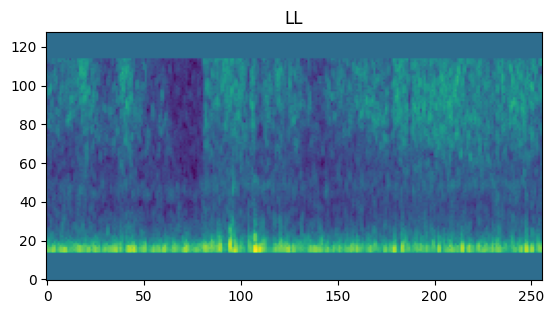

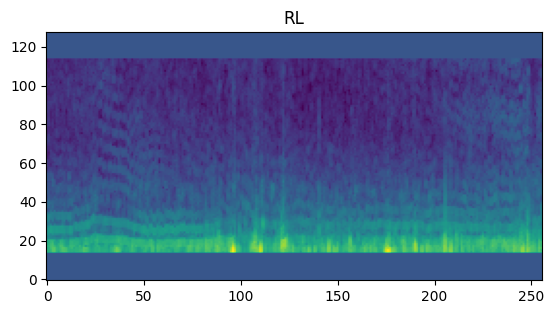

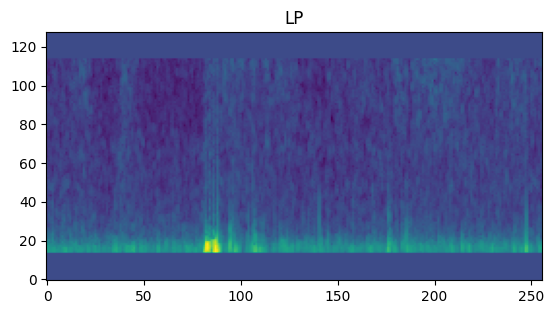

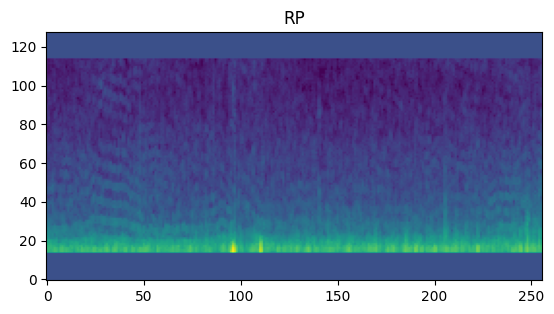

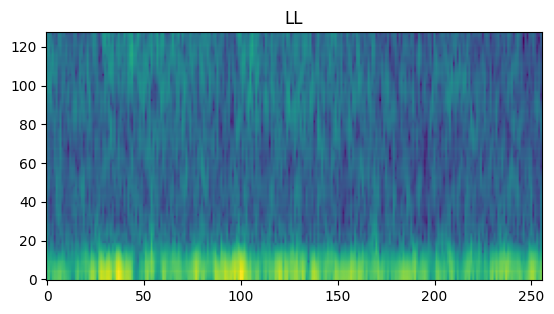

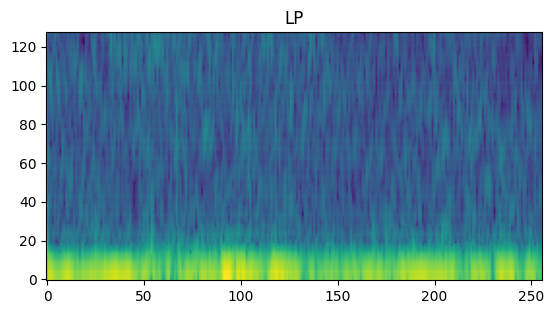

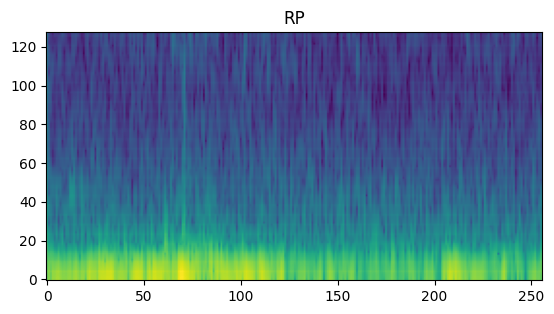

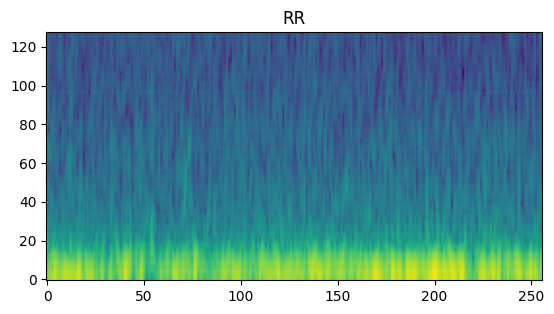

In [83]:
testing_specs, testing_main_target, testing_all_targets, testing_eeg_id = test_dataset[0]

print("Main target", testing_main_target)
print("All targets", testing_all_targets)
print("EEG Id", testing_eeg_id)

print("Shape", testing_specs.shape)

for idx, spec_type in enumerate(SPEC_TYPES+REVERSED_SPEC_TYPES):
    plt.title(spec_type)
    plt.imshow(testing_specs[idx].numpy())
    plt.gca().invert_yaxis()
    plt.show()

In [84]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    drop_last=False,
    shuffle=False,
    num_workers=4
)

In [86]:
model = [create_model_and_load_best_checkpoint(
        model_class=SpecCNNClasifier,
        model_config=dict(
            pretrained=False,
            backbone=backbone_architecture,
            n_specs=8,
            n_classes=6,
            spec_augment_config={
                "freq_mask": {
                    "mask_max_length": 20,
                    "mask_max_masks": 5,
                    "p": 1.0,
                    "inplace": True,
                },
                "time_mask": {
                    "mask_max_length": 30,
                    "mask_max_masks": 5,
                    "p": 1.0,
                    "inplace": True,
                },
            }
        ),
        model_device="cuda",
        model_chkp_root=f"logdirs/hms_baseline/fold_{m_i}/checkpoints",
        model_chkp_regex=r'(?P<key>\w+)=(?P<value>[\d.]+)(?=\.ckpt|$)',
        sort_rule=lambda x: float(x["valid_kl"]),
        delete_prefix="model."
) for m_i in range(5)]

All checkpoints
[{'name': 'epoch=2-step=321-valid_kl=0.708.ckpt', 'valid_kl': '0.708'},
 {'name': 'epoch=1-step=214-valid_kl=0.745.ckpt', 'valid_kl': '0.745'},
 {'name': 'epoch=3-step=428-valid_kl=0.685.ckpt', 'valid_kl': '0.685'}]
Sorted checkpoints
[{'name': 'epoch=3-step=428-valid_kl=0.685.ckpt', 'valid_kl': '0.685'},
 {'name': 'epoch=2-step=321-valid_kl=0.708.ckpt', 'valid_kl': '0.708'},
 {'name': 'epoch=1-step=214-valid_kl=0.745.ckpt', 'valid_kl': '0.745'}]
Best checkpoint
logdirs/hms_baseline/fold_0/checkpoints/epoch=3-step=428-valid_kl=0.685.ckpt
All checkpoints
[{'name': 'epoch=2-step=306-valid_kl=0.716.ckpt', 'valid_kl': '0.716'},
 {'name': 'epoch=1-step=204-valid_kl=0.786.ckpt', 'valid_kl': '0.786'},
 {'name': 'epoch=3-step=408-valid_kl=0.684.ckpt', 'valid_kl': '0.684'}]
Sorted checkpoints
[{'name': 'epoch=3-step=408-valid_kl=0.684.ckpt', 'valid_kl': '0.684'},
 {'name': 'epoch=2-step=306-valid_kl=0.716.ckpt', 'valid_kl': '0.716'},
 {'name': 'epoch=1-step=204-valid_kl=0.786.ck

In [89]:
@torch.inference_mode()
def inference_function(
    loader,
    nn_models,
    output_key,
    device
):
    predicted_df = {"eeg_id": []}
    for target in TARGETS:
        predicted_df[target.lower() + "_vote"] = []

    for batch in tqdm(loader):
        specs, _, _, eeg_id = batch
        pred_probs = []
        for nn_model in nn_models:
            local_probs = nn_model(specs.to(device))[output_key]
            local_probs = torch.softmax(local_probs, dim=1)
            local_probs = local_probs.detach().cpu().numpy()
            pred_probs.append(local_probs)
        pred_probs = np.stack(pred_probs, axis=0).mean(0)
        predicted_df["eeg_id"].append(eeg_id.cpu().numpy())
        for i, target in enumerate(TARGETS):
            predicted_df[target.lower() + "_vote"].append(pred_probs[:, i])

    for key in predicted_df:
        predicted_df[key] = np.concatenate(predicted_df[key])

    predicted_df = pd.DataFrame(predicted_df)

    return predicted_df

In [90]:
predicted_df = inference_function(
    loader=test_loader,
    nn_models=model,
    output_key="logits",
    device="cuda"
)

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


In [91]:
predicted_df

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.395426,0.041493,0.004997,0.200686,0.040895,0.316502


In [92]:
predicted_df[[el.lower() + "_vote" for el in TARGETS]].sum(axis=1)

0    1.0
dtype: float32

In [93]:
ls ./

logdirs/  temp/


In [94]:
rm ./* -rf

In [95]:
ls ./

In [98]:
predicted_df.to_csv('submission.csv', index=False)